# Test `compare_tide_prediction_max_ssh` Module

Render figure object produced by the `nowcast.figures.publish.compare_tide_prediction_max_ssh` module.
Provides data for visual testing to confirm that refactoring has not adversely changed figure for web page.

Set-up and function call replicates as nearly as possible what is done in the `nowcast.workers.make_plots` worker.

In [1]:
import io
from pathlib import Path

import arrow
import netCDF4 as nc
import yaml

from salishsea_tools import nc_tools

from nowcast.figures import figures
from nowcast.figures.publish import compare_tide_prediction_max_ssh

In [2]:
%matplotlib inline

**NOTE**

The next cell mounts the `/results` filesystem on `skookum` and the `/ocean` filesystem locally.
It is intended for use if when this notebook is run on a laptop or other
non-Waterhole machine that has `sshfs` installed 
and mount points for `/results` and `/ocean` available in its root filesystem.

Don't execute the cell if that doesn't describe your situation.

!sshfs skookum:/results /results
!sshfs skookum:/ocean /ocean

In [3]:
config = '''
    timezone: Canada/Pacific
    
    bathymetry: /results/nowcast-sys/NEMO-forcing/grid/bathy_meter_SalishSea2.nc

    ssh:
        tidal_predictions: /results/nowcast-sys/tools/SalishSeaNowcast/tidal_predictions/

    weather:
        ops_dir: /results/forcing/atmospheric/GEM2.5/operational/

    run:
        results_archive:
            nowcast: /results/SalishSea/nowcast/
            forecast: /results/SalishSea/forecast/
'''

config = yaml.load(io.StringIO(config))

In [4]:
run_date = arrow.get('2016-06-09')
run_type = 'nowcast'

dmy = run_date.format('DDMMMYY').lower()
start_day = {
    'nowcast': run_date.format('YYYYMMDD'),
    'forecast': run_date.replace(days=+1).format('YYYYMMDD'),
}
end_day = {
    'nowcast': run_date.format('YYYYMMDD'),
    'forecast': run_date.replace(days=+2).format('YYYYMMDD'),
}
ymd = run_date.format('YYYYMMDD')

results_home = Path(config['run']['results_archive'][run_type])
results_dir = results_home/dmy
place_names = [
    'Point Atkinson', 'Victoria', 'Campbell River', 'Cherry Point',
    'Friday Harbor', 'Neah Bay', 'Nanaimo', 'Sandheads',
]
weather_path = Path(config['weather']['ops_dir'])
if run_type in ('forecast', ('foreacst2')):
    weather_path = weather_path/'fcst'

In [5]:
bathy = nc.Dataset(config['bathymetry'])
grid_T_hr = nc.Dataset(
    str(results_dir/'SalishSea_1h_{0}_{1}_grid_T.nc'
        .format(start_day[run_type], end_day[run_type])))
grids_15m = {
    place_name: nc.Dataset(str(results_dir/'{}.nc'.format(place_name.replace(' ', ''))))
    for place_name in place_names
}
weather_path= str(weather_path)
tidal_predictions = config['ssh']['tidal_predictions']

1 loop, best of 1: 2.98 s per loop


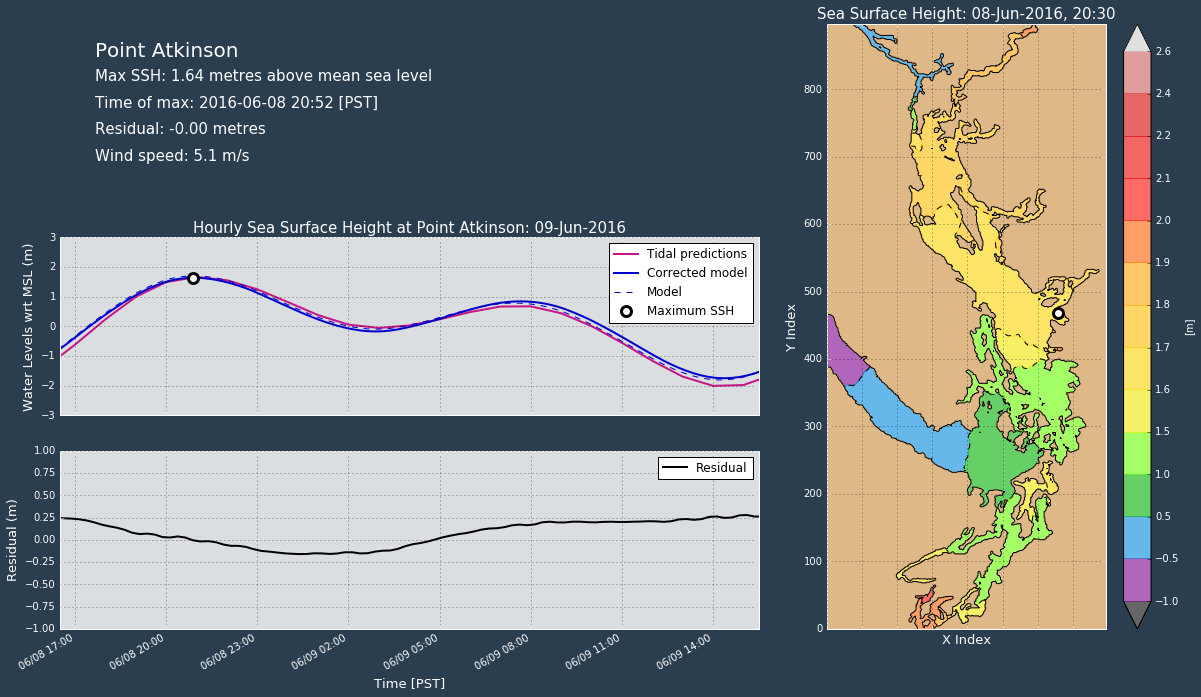

In [6]:
%%timeit -n1 -r1

# Reference rendering of figure

fig = figures.compare_tidalpredictions_maxSSH(
    grid_T_hr, bathy, grids_15m, weather_path, tidal_predictions,
    PST=1, MSL=0, name='Point Atkinson')

1 loop, best of 1: 3.28 s per loop


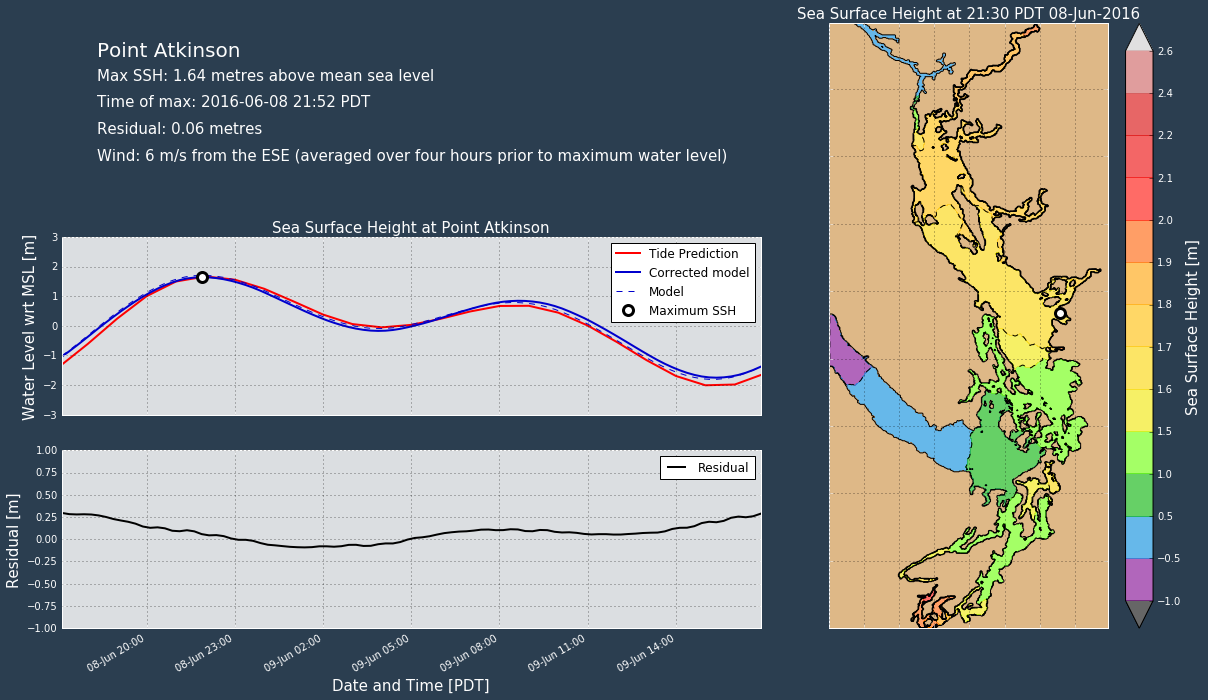

In [17]:
%%timeit -n1 -r1

# Refactored rendering of figure

from importlib import reload
from nowcast.figures import website_theme
from salishsea_tools import places
reload(compare_tide_prediction_max_ssh)
reload(website_theme)
reload(places)

fig = compare_tide_prediction_max_ssh.compare_tide_prediction_max_ssh(
    'Point Atkinson', grid_T_hr, grids_15m, bathy,
    weather_path, tidal_predictions, config['timezone'],
    theme=website_theme)